In [293]:
# imports
from pathlib import Path
import copy
import json
import rasterio
import re
import numpy as np

# python script imports
import BK_utils

# weird import fix from https://stackoverflow.com/questions/1250103/attributeerror-module-object-has-no-attribute
from importlib import reload
reload(BK_utils)

<module 'BK_utils' from '/home/ben/scripts/2025-KI-Seminar/BK_utils.py'>

In [294]:
def load_tif_files(path):
    """Load tif files from the given path."""
    # load the tif files
    with rasterio.open(path) as src:
        # read the data
        data = src.read()
        # get the metadata
        meta = src.meta
        # get the data type
        dtypes = ["landcover", "DO_DTM+DSM_mosaic", "DO_DSM_mosaic", "Tmrt", "wall_height", "wall_aspect", "SkyViewFactor"]
        # check the data type
        for dtype in dtypes:
            if dtype in path.name:
                tiftype = dtype
                break
        else:
            tiftype = "unknown"
            print(f"Warning: {path.name} does not match any known data type. Defaulting to 'unknown'.")

    # return the data and metadata
    parent_folder_name = path.parent.name
    return {parent_folder_name: {path.name: {"data": data, "meta": meta, "type": tiftype, "train": None, "test": None}}}
    
# load the dataset
data_path = Path("data/static")
data_dict = {}

# iterate over the directories

for directory in data_path.iterdir():
    # check dir regex on 2int_2int so XX_XX
    if re.match(r"\d{2}_\d{2}", directory.name):
        for file in directory.iterdir():
            # only load tif, skip other files
            if file.suffix != ".tif":
                continue
            print(f"Loading {file.name} from {directory.name}...", end="")
            data = load_tif_files(file)
            print(" done")

            # add the data to the dictionary with the file name as the key
            if directory.name not in data_dict:
                data_dict[directory.name] = {}
            if file.name not in data_dict[directory.name]:
                data_dict[directory.name][file.name] = data[directory.name][file.name]
    else:
        print(f"Skipping {directory.name} as it does not match the regex")

print("\nData loaded successfully!\nDisplaying the data dictionary:\n")
BK_utils.display_dict(data_dict)


Loading DO_DTM+DSM_mosaic_3m_02_04.tif from 02_04... done
Loading DO_landcover_3m_reclassified_final_02_04.tif from 02_04... done
Loading 02_04_Tmrt_3m_v0.6.0_2024_093_1000D.tif from 02_04... done
Loading wall_height_02_04.tif from 02_04... done
Loading SkyViewFactor_02_04.tif from 02_04... done
Loading wall_aspect_02_04.tif from 02_04... done
Loading DO_DSM_mosaic_3m_bilinear_masked_trees_02_04.tif from 02_04... done

Data loaded successfully!
Displaying the data dictionary:

{
  '02_04':   {
    'DO_DTM+DSM_mosaic_3m_02_04.tif':     {
      'data': <iterable ndarray>
      'meta':       {
        'driver': 'GTiff'
        'dtype': 'float32'
        'nodata': 3.4028234663852886e+38
        'width': 1000
        'height': 1000
        'count': 1
        'crs': <iterable CRS>
        'transform': tuple with 9 items [
          3.0
          0.0
          387200.0
          0.0
          -3.0
          5716600.0
          0.0
          0.0
          1.0
        ]
      }
      'type': 'D

Processing complete. Tiles are prepared for regrouping.
Displaying one tile of each band:


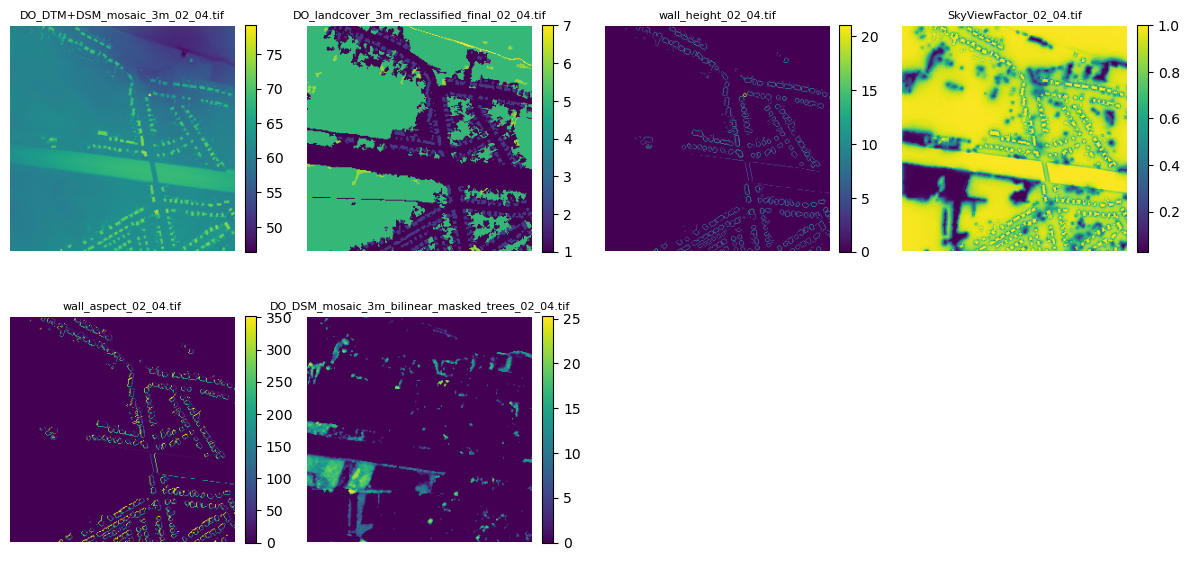

Testing reconstructing original rasters for display ..


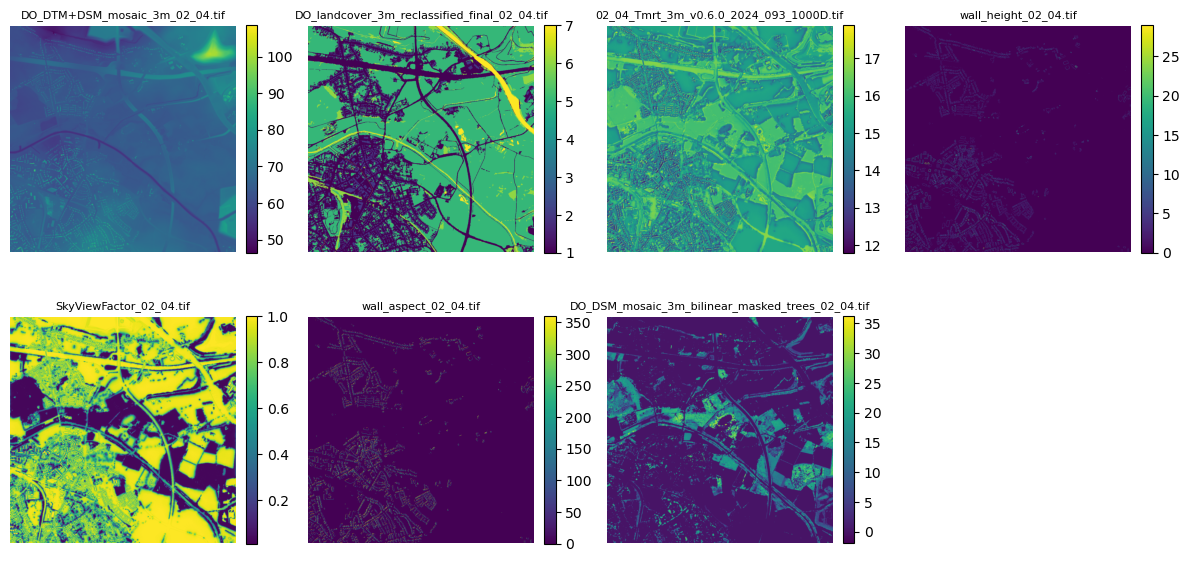

X_train shape: (16, 6, 250, 250)
y_train shape: (16, 1, 250, 250)


In [295]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Work with the '02_04' datacube
datacube_id = '02_04'
datacube = data_dict[datacube_id]

x_bands = {}
y_bands = {}
tile_metadata = {}

import numpy as np

def tile_raster(x: np.ndarray, tile_size: int = 250, filename: str = ""):
    """Tile the raster into smaller chunks and keep track of positions for reconstruction.
    
    Args:
        x (np.ndarray): The input 2D array to be tiled.
        tile_size (int, optional): Size of each tile. Defaults to 250.
        filename (str, optional): Name associated with the file. Defaults to "".
        
    Returns:
        tiles (list): List of tiled chunks.
        metadata (list): Metadata for each tile containing its position and other info.
    """
    c, h, w = x.shape
    h_tiles = h // tile_size
    w_tiles = w // tile_size

    tiles = []
    metadata = []

    for i in range(h_tiles):
        for j in range(w_tiles):
            start_row = i * tile_size
            end_row = (i + 1) * tile_size
            start_col = j * tile_size
            end_col = (j + 1) * tile_size
            
            tile = x[:, start_row:end_row, start_col:end_col]
            
            # Assign group number based on i and j (customize this logic as needed)
            group_number = (i // 4) + (j // 4)
            
            metadata_entry = {
                "filename": filename,
                "tile_row": i,
                "tile_col": j,
                "group": group_number,  # Group number for regrouping
                "tile_size": tile_size,
                "original_shape": (c, h, w),
            }
            
            tiles.append(tile)
            metadata.append(metadata_entry)

    return tiles, metadata

def process_datacube(datacube):
    """Process each file in the datacube and prepare tiled data.
    
    Args:
        datacube (dict): Dictionary containing files to process.
        
    Returns:
        tile_metadata (dict): Metadata for reconstruction.
        y_bands (dict): Tiled data for "Tmrt" types.
        x_bands (dict): Tiled data for other types.
    """
    tile_metadata = {}
    y_bands = {}  # For files of type "Tmrt"
    x_bands = {}   # For other file types
    
    for filename, file_info in datacube.items():
        raster = file_info['data']
        
        if raster.size == 0:
            print(f"Warning: {filename} is empty. Skipping.")
            continue
        if raster.ndim != 3:
            print(f"Warning: {filename} has {raster.ndim} dimensions. Expected 3. Skipping.")
            continue
        
        tiled_data, metadata = tile_raster(raster, tile_size=250, filename=filename)
        
        # Store metadata for later use in reconstruction
        tile_metadata[filename] = metadata
        
        if file_info['type'] == "Tmrt":
            y_bands[filename] = tiled_data
        else:
            x_bands[filename] = tiled_data

    # split the metadata into train and test
    for filename, metadata in tile_metadata.items():
        for i, entry in enumerate(metadata):
            if entry["tile_row"] % 2 == 0 and entry["tile_col"] % 2 == 0:
                entry["train"] = True
                entry["test"] = False
            else:
                entry["train"] = False
                entry["test"] = True
    return tile_metadata, y_bands, x_bands
# Display the datacube

# Process the datacube
# Note: The datacube variable should be defined in your context
    

# Replace 'datacube' with your actual datacube dictionary

tile_metadata, y_bands, x_bands = process_datacube(datacube)

print("Processing complete. Tiles are prepared for regrouping.")


# Display only one tile of each band as subplots
def display_one_tile_per_band(bands, titles=None, cmap='viridis', cols=4):
    """Display one tile from each band as subplots in a grid layout."""
    num_bands = len(bands)
    rows = math.ceil(num_bands / cols)  # Determine number of rows

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))  # Adjust subplot size
    axes = np.array(axes).flatten()  # Flatten axes for easy iteration

    for i, (filename, tiles) in enumerate(bands.items()):
        ax = axes[i]
        tile = tiles[0]  # Select the first tile of each band

        # Remove channel dimension if only 1 band
        if tile.shape[0] == 1:
            tile = tile[0]
        else:
            tile = np.mean(tile, axis=0)

        im = ax.imshow(tile, cmap=cmap)
        ax.set_title(titles[i] if titles else filename, fontsize=8)
        ax.axis('off')
        
        # Add colorbar for each subplot
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Display one tile of each band
print("Displaying one tile of each band:")
display_one_tile_per_band(x_bands, titles=list(x_bands.keys()), cmap='viridis')


# Reconstruct the original rasters
print("Testing reconstructing original rasters for display ..")
reconstructed_rasters = BK_utils.process_and_reconstruct(x_bands, y_bands, tile_metadata, tile_size=250)
# Display the reconstructed rasters
BK_utils.display_rasters(reconstructed_rasters, titles=list(reconstructed_rasters.keys()), cmap='viridis')


# Convert bands into a single numpy array
X_train = np.concatenate([np.stack(tiles, axis=0) for tiles in x_bands.values()], axis=1)
y_train = np.concatenate([np.stack(tiles, axis=0) for tiles in y_bands.values()], axis=1)

print("X_train shape:", X_train.shape)  # Expect (16, C, 250, 250)
print("y_train shape:", y_train.shape)  # Expect (16, C, 250, 250)



In [296]:
# create a Convolutional Neural Network (CNN) model
# X_train shape: (16, 6, 1000, 1000)
# y_train shape: (16, 1, 1000, 1000)

# split into train and test tiles (tiles are 16)
a, b, c, d = BK_utils.split_train_test(X_train, y_train, test_size=0.2)

print("X_train shape:", a.shape)  # Expect (12, 6, 250, 250)
print("y_train shape:", b.shape)  # Expect (12, 1, 250, 250)
print("X_test shape:", c.shape)  # Expect (4, 6, 250, 250)
print("y_test shape:", d.shape)  # Expect (4, 1, 250, 250)




# Reshape the data to fit the model input

# define the model parameters
param_dict = {
    "model_name": "CNN",
    "model_type": "conv2d",
    "input_type": "raster",
    "model_compiler_metadata": {
        "input_shape": (6, 250, 250),  # Adjusted to match the tiled data
        "filters": (32, 64, 128),
        "kernel_size": (3, 3),
        "pool_size": (2, 2),
        "activation": "relu",
        "use_batchnorm": True,
        "final_activation": "sigmoid",
        "loss": "binary_crossentropy",
        "optimizer": "adam",
        "metrics": ["accuracy"],
    },
    "model_training_metadata": {
        "batch_size": 32,
        "epochs": 10,
        "validation_split": 0.2,
        "shuffle": True,
        "callbacks": {
            "EarlyStopping": {
                "monitor": "val_loss",
                "patience": 3,
                "restore_best_weights": True
            }
        }
    },
    "model_evaluation_metadata": {
        "metrics": ["accuracy", "precision", "recall", "f1_score"],
        "confusion_matrix": True,
        "classification_report": True,
        "roc_auc": True
    },
}

model = BK_utils.create_compiled_conv2d_model(param_dict)

# # summarize the model
model.summary()

X_train shape: (12, 6, 250, 250)
y_train shape: (4, 6, 250, 250)
X_test shape: (12, 1, 250, 250)
y_test shape: (4, 1, 250, 250)
Model Compiler Metadata: {'input_shape': (6, 250, 250), 'filters': (32, 64, 128), 'kernel_size': (3, 3), 'pool_size': (2, 2), 'activation': 'relu', 'use_batchnorm': True, 'final_activation': 'sigmoid', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 6, 250, 250)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 6, 250, 32)     │        72,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_90          │ (None, 6, 250, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_90 (Activation)      │ (None, 6, 250, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 3, 125, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 3, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_91          │ (None, 3, 125, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_91 (Activation)      │ (None, 3, 125, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 1, 62, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_114 (Conv2D)             │ (None, 1, 62, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_92          │ (None, 1, 62, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_92 (Activation)      │ (None, 1, 62, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_36 (UpSampling2D) │ (None, 2, 124, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 2, 124, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_93          │ (None, 2, 124, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_93 (Activation)      │ (None, 2, 124, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_37 (UpSampling2D) │ (None, 4, 248, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 4, 248, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 4, 248, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_94 (Activation)      │ (None, 4, 248, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_117 (Conv2D)             │ (None, 4, 248, 1)      │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257,953 (1007.63 KB)

 Trainable params: 257,313 (1005.13 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
# train the model
# shapes are (12, 6, 250, 250) and (12, 1, 250, 250)


history = model.fit(
    a,  # X_train
    b,  # y_train
    batch_size=param_dict["model_training_metadata"]["batch_size"],
    epochs=param_dict["model_training_metadata"]["epochs"],
    validation_split=param_dict["model_training_metadata"]["validation_split"],
    shuffle=param_dict["model_training_metadata"]["shuffle"]
)


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 9
'y' sizes: 4
